In [30]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras import Sequential, Input
from keras.layers import Dense
from keras.activations import relu, softmax
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam
from keras import callbacks
import keras

In [12]:
df_submission = pd.read_csv('./playground-series-s4e2/sample_submission.csv')
df_train = pd.read_csv('./playground-series-s4e2/train.csv')
df_train_obesity_cvd=pd.read_csv('./archive/ObesityDataSet.csv')
df_test = pd.read_csv('./playground-series-s4e2/test.csv')

In [4]:
df_train.columns

Index(['id', 'Gender', 'Age', 'Height', 'Weight',
       'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
       'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [13]:
df_train = df_train.drop("id",axis=1)
df_test=df_test.drop("id",axis=1)
df_train.shape

(20758, 17)

In [14]:
# Concatinating training data from all sources
df_train = pd.concat([df_train, df_train_obesity_cvd])
df_train=df_train.drop_duplicates()

In [15]:
df_train['NObeyesdad'].value_counts()


NObeyesdad
Obesity_Type_III       4370
Obesity_Type_II        3545
Normal_Weight          3364
Obesity_Type_I         3261
Overweight_Level_II    2812
Insufficient_Weight    2790
Overweight_Level_I     2703
Name: count, dtype: int64

In [16]:
# Encoding categorical variables (one-hot encoding)

non_numerical_columns = ["Gender", "family_history_with_overweight",
                         "FAVC", "CAEC", "SMOKE", "SCC", "CALC", "MTRANS"]
encoded_df_train = pd.get_dummies(df_train, columns=non_numerical_columns)
encoded_df_test = pd.get_dummies(df_test, columns=non_numerical_columns)

# encoded_df_train.head()

In [17]:
# Normalizing numerical features
numerical_columns = ["Age", "Height", "Weight",
                     "FCVC", "NCP", "CH2O", "FAF", "TUE"]
scaler = StandardScaler()
encoded_df_train[numerical_columns] = scaler.fit_transform(
    encoded_df_train[numerical_columns])
# encoded_df_train.head()

In [18]:
label_encoder = LabelEncoder()


#  encoding NObeyesdad feature since it takes values of string type
encoded_df_train['NObeyesdad'] = label_encoder.fit_transform(
    encoded_df_train['NObeyesdad'])
# encoded_df_train.head()

In [28]:
print(f"{encoded_df_train['NObeyesdad'].value_counts()}\n\n\n{df_train['NObeyesdad'].value_counts()}")

NObeyesdad
4    4370
3    3545
1    3364
2    3261
6    2812
0    2790
5    2703
Name: count, dtype: int64


NObeyesdad
Obesity_Type_III       4370
Obesity_Type_II        3545
Normal_Weight          3364
Obesity_Type_I         3261
Overweight_Level_II    2812
Insufficient_Weight    2790
Overweight_Level_I     2703
Name: count, dtype: int64


In [13]:
# Extracting (feature) X and (result) y variable from training set

X = encoded_df_train.drop(['NObeyesdad'], axis=1)
y = encoded_df_train['NObeyesdad']

In [14]:
X.shape, y.shape

((22845, 31), (22845,))

In [15]:
#  train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Cross-validation split

X_train, X_val, y_train, y_val=train_test_split(
    X_train, y_train, test_size=0.1, random_state=45)


In [16]:
# Transforming training and test data to numpy array
X_train = np.asarray(X_train).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)

X_test = np.asarray(X_test).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

X_val = np.asarray(X_val).astype(np.float32)
y_val = np.asarray(y_val).astype(np.float32)

# Model Building

In [17]:
model = Sequential(
    [
        Input(shape=(X_train.shape[1],)),
        Dense(30, activation=relu,kernel_regularizer= keras.regularizers.l2(0.009)),
        Dense(15, activation=relu,kernel_regularizer= keras.regularizers.l2(0.009)),
        Dense(7, activation=softmax)
    ],
)

In [18]:
model.compile(optimizer=Adam(learning_rate=0.001), loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'],
              )

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 30)                960       
                                                                 
 dense_1 (Dense)             (None, 15)                465       
                                                                 
 dense_2 (Dense)             (None, 7)                 112       
                                                                 
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
callbacks = [
    callbacks.EarlyStopping(monitor="val_loss",
                                        mode="min", patience=5,
                                        restore_best_weights=True)
]

In [21]:

history = model.fit(X_train, y_train, epochs=100,
                     validation_data=(X_val,y_val),callbacks=callbacks)

Epoch 1/100


/home/dheeraj/.local/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


514/514 [==============================] - 4s 4ms/step - loss: 1.3872 - accuracy: 0.6186 - val_loss: 0.9257 - val_accuracy: 0.7784
Epoch 2/100
514/514 [==============================] - 2s 4ms/step - loss: 0.8165 - accuracy: 0.8232 - val_loss: 0.7630 - val_accuracy: 0.8359
Epoch 3/100
514/514 [==============================] - 2s 4ms/step - loss: 0.7124 - accuracy: 0.8514 - val_loss: 0.6954 - val_accuracy: 0.8463
Epoch 4/100
514/514 [==============================] - 2s 4ms/step - loss: 0.6632 - accuracy: 0.8610 - val_loss: 0.6564 - val_accuracy: 0.8545
Epoch 5/100
514/514 [==============================] - 2s 3ms/step - loss: 0.6326 - accuracy: 0.8630 - val_loss: 0.6409 - val_accuracy: 0.8490
Epoch 6/100
514/514 [==============================] - 2s 3ms/step - loss: 0.6101 - accuracy: 0.8624 - val_loss: 0.6107 - val_accuracy: 0.8534
Epoch 7/100
514/514 [==============================] - 2s 4ms/step - loss: 0.5919 - accuracy: 0.8642 - val_loss: 0.5898 - val_accuracy: 0.8682
Epoch 8/100

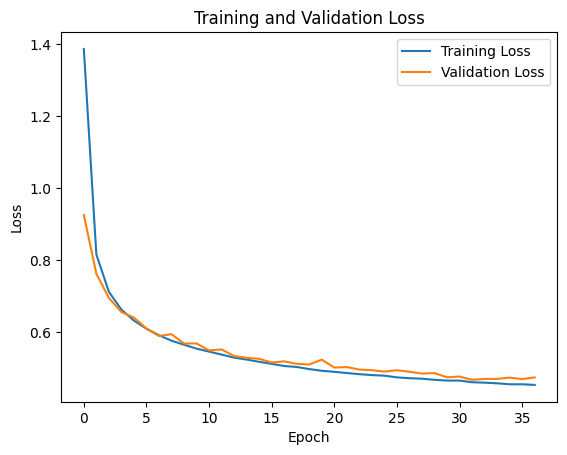

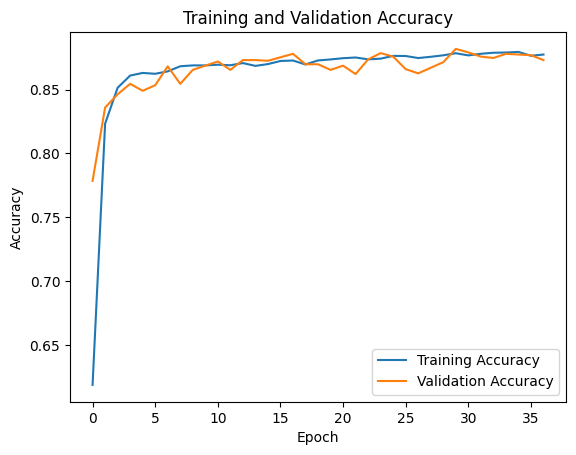

In [22]:
# Visualize training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [30]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')
print(f'Test Loss: {loss}')

143/143 [==============================] - 0s 1ms/step - loss: 0.3732 - accuracy: 0.8735
Test Accuracy: 0.8734952807426453
Test Loss: 0.3731597363948822


In [1]:
# model.predict()
encoded_df_test.head()

pd.to_csv

NameError: name 'encoded_df_test' is not defined

In [32]:
model1=keras.models.load_model('model1.keras')

TypeError: Error when deserializing class 'InputLayer' using config={'batch_shape': [None, 28], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}.

Exception encountered: Unrecognized keyword arguments: ['batch_shape']